# Entity and Relationship Extraction Statistics

This notebook analyzes and visualizes the statistics of extracted entities and relationships from threat intelligence data.

## Overview
- **Entity Analysis**: Count and distribution of different entity types
- **Relationship Analysis**: Count and distribution of relationship types
- **Performance Metrics**: Extraction performance across different models
- **Data Quality**: Analysis of extraction quality and completeness


In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 1. Load and Prepare Data


In [17]:
# Define data paths
DATA_DIR = Path('../data')
ENTITY_EXTRACTION_DIR = DATA_DIR / 'entity-extraction'
ENTITIES_DIR = DATA_DIR / 'entities'

# Load main extraction data
extraction_files = {
    'llama3': ENTITY_EXTRACTION_DIR / 'merged_llama3_extractions_full_content.json',
    'qwen3_14b': ENTITY_EXTRACTION_DIR / 'Qwen3-14B_2025-08-23_10-14-28_0_427.json'
}

def load_extraction_data(file_path):
    """Load and parse extraction data from JSON file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Loaded {len(data)} records from {file_path.name}")
        return data
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

# Load all extraction data
extraction_data = {}
for model_name, file_path in extraction_files.items():
    if file_path.exists():
        extraction_data[model_name] = load_extraction_data(file_path)
    else:
        print(f"⚠️  File not found: {file_path}")


✅ Loaded 300 records from merged_llama3_extractions_full_content.json
✅ Loaded 427 records from Qwen3-14B_2025-08-23_10-14-28_0_427.json


In [18]:
# Load processed entity CSVs
entity_files = {
    'attackers': 'attackers.csv',
    'malware': 'malware.csv', 
    'tools': 'tools.csv',
    'vulnerabilities': 'vulnerabilities.csv',
    'files': 'files.csv',
    'hashes': 'hashes.csv',
    'ips': 'ips.csv',
    'urls': 'urls.csv',
    'devices': 'devices.csv',
    'techniques': 'techniques.csv'
}

entity_dataframes = {}
for entity_type, filename in entity_files.items():
    file_path = ENTITIES_DIR / filename
    if file_path.exists():
        df = pd.read_csv(file_path)
        entity_dataframes[entity_type] = df
        print(f"✅ Loaded {len(df)} {entity_type} entities")
    else:
        print(f"⚠️  Entity file not found: {filename}")

# Load relationships
relationships_file = DATA_DIR / 'relationships_norm.csv'
if relationships_file.exists():
    relationships_df = pd.read_csv(relationships_file)
    print(f"✅ Loaded {len(relationships_df)} relationships")
else:
    print(f"⚠️  Relationships file not found: {relationships_file}")


✅ Loaded 70 attackers entities
✅ Loaded 46 malware entities
✅ Loaded 102 tools entities
✅ Loaded 25 vulnerabilities entities
✅ Loaded 9 files entities
⚠️  Entity file not found: hashes.csv
⚠️  Entity file not found: ips.csv
✅ Loaded 3 urls entities
⚠️  Entity file not found: devices.csv
✅ Loaded 17 techniques entities
✅ Loaded 59 relationships


In [19]:
# Create comprehensive statistics table
print("📋 COMPREHENSIVE ENTITY EXTRACTION STATISTICS")
print("=" * 60)

# Processed entities summary
if entity_dataframes:
    print("\n🗂️  PROCESSED ENTITIES (From CSV Files):")
    processed_summary = []
    total_processed = 0
    
    for entity_type, df in entity_dataframes.items():
        count = len(df)
        total_processed += count
        unique_names = df['name'].nunique() if 'name' in df.columns else 'N/A'
        processed_summary.append({
            'Entity Type': entity_type.title(),
            'Total Count': f"{count:,}",
            'Unique Names': f"{unique_names:,}" if unique_names != 'N/A' else 'N/A'
        })
    
    processed_df = pd.DataFrame(processed_summary)
    print(processed_df.to_string(index=False))
    print(f"\n📊 TOTAL PROCESSED ENTITIES: {total_processed:,}")

# Relationships summary
if 'relationships_df' in locals():
    print("\n🔗 RELATIONSHIPS STATISTICS:")
    print(f"Total Relationships: {len(relationships_df):,}")
    print(f"Unique Relationship Types: {relationships_df['relation'].nunique()}")
    print(f"Unique Source Entities: {relationships_df['source_id'].nunique():,}")
    print(f"Unique Target Entities: {relationships_df['target_id'].nunique():,}")
    
    print("\n🔝 TOP 10 RELATIONSHIP TYPES:")
    top_relations = relationships_df['relation'].value_counts().head(10)
    for i, (relation, count) in enumerate(top_relations.items(), 1):
        print(f"{i:2d}. {relation}: {count:,}")


📋 COMPREHENSIVE ENTITY EXTRACTION STATISTICS

🗂️  PROCESSED ENTITIES (From CSV Files):
    Entity Type Total Count Unique Names
      Attackers          70           70
        Malware          46           46
          Tools         102          102
Vulnerabilities          25           25
          Files           9            9
           Urls           3            3
     Techniques          17           17

📊 TOTAL PROCESSED ENTITIES: 272

🔗 RELATIONSHIPS STATISTICS:
Total Relationships: 59
Unique Relationship Types: 36
Unique Source Entities: 35
Unique Target Entities: 45

🔝 TOP 10 RELATIONSHIP TYPES:
 1. uses: 9
 2. publishes: 4
 3. used_by: 3
 4. hosts: 3
 5. targets: 3
 6. operates: 3
 7. detects: 2
 8. exploits: 2
 9. is_alias_for: 2
10. developed: 2


## 4. Model Performance Comparison


In [20]:
# Model comparison analysis
if len(model_entity_stats) > 1:
    print("\n🏆 MODEL PERFORMANCE COMPARISON")
    print("=" * 50)
    
    comparison_data = []
    
    for model_name, stats in model_entity_stats.items():
        total_entities = sum(stats.values())
        unique_types = len(stats)
        avg_per_type = total_entities / unique_types if unique_types > 0 else 0
        
        # Top 3 entity types for this model
        top_3 = stats.most_common(3)
        top_types_str = ", ".join([f"{et}({count})" for et, count in top_3])
        
        comparison_data.append({
            'Model': model_name.upper(),
            'Total Entities': f"{total_entities:,}",
            'Unique Types': unique_types,
            'Avg per Type': f"{avg_per_type:.1f}",
            'Top 3 Types': top_types_str
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

# Extraction efficiency analysis
if extraction_data:
    print("\n⚡ EXTRACTION EFFICIENCY")
    print("=" * 30)
    
    for model_name, data in extraction_data.items():
        if data:
            total_articles = len(data)
            articles_with_entities = 0
            articles_with_relationships = 0
            
            for record in data:
                if 'extraction' in record:
                    extraction = record['extraction']
                    
                    # Check for entities
                    if 'entities' in extraction and extraction['entities']:
                        articles_with_entities += 1
                    
                    # Check for relationships
                    if 'relationships' in extraction and extraction['relationships']:
                        articles_with_relationships += 1
            
            entity_rate = (articles_with_entities / total_articles * 100) if total_articles > 0 else 0
            relationship_rate = (articles_with_relationships / total_articles * 100) if total_articles > 0 else 0
            
            print(f"\n📈 {model_name.upper()}:")
            print(f"  Total Articles: {total_articles:,}")
            print(f"  Articles with Entities: {articles_with_entities:,} ({entity_rate:.1f}%)")
            print(f"  Articles with Relationships: {articles_with_relationships:,} ({relationship_rate:.1f}%)")



🏆 MODEL PERFORMANCE COMPARISON
    Model Total Entities  Unique Types Avg per Type                                 Top 3 Types
   LLAMA3          1,327            40         33.2 vendor(256), threatactor(212), malware(178)
QWEN3_14B              0             0          0.0                                            

⚡ EXTRACTION EFFICIENCY

📈 LLAMA3:
  Total Articles: 300
  Articles with Entities: 263 (87.7%)
  Articles with Relationships: 192 (64.0%)

📈 QWEN3_14B:
  Total Articles: 427
  Articles with Entities: 403 (94.4%)
  Articles with Relationships: 398 (93.2%)


## 5. Enhanced Visualizations (Similar to Paper Figure 4.4)


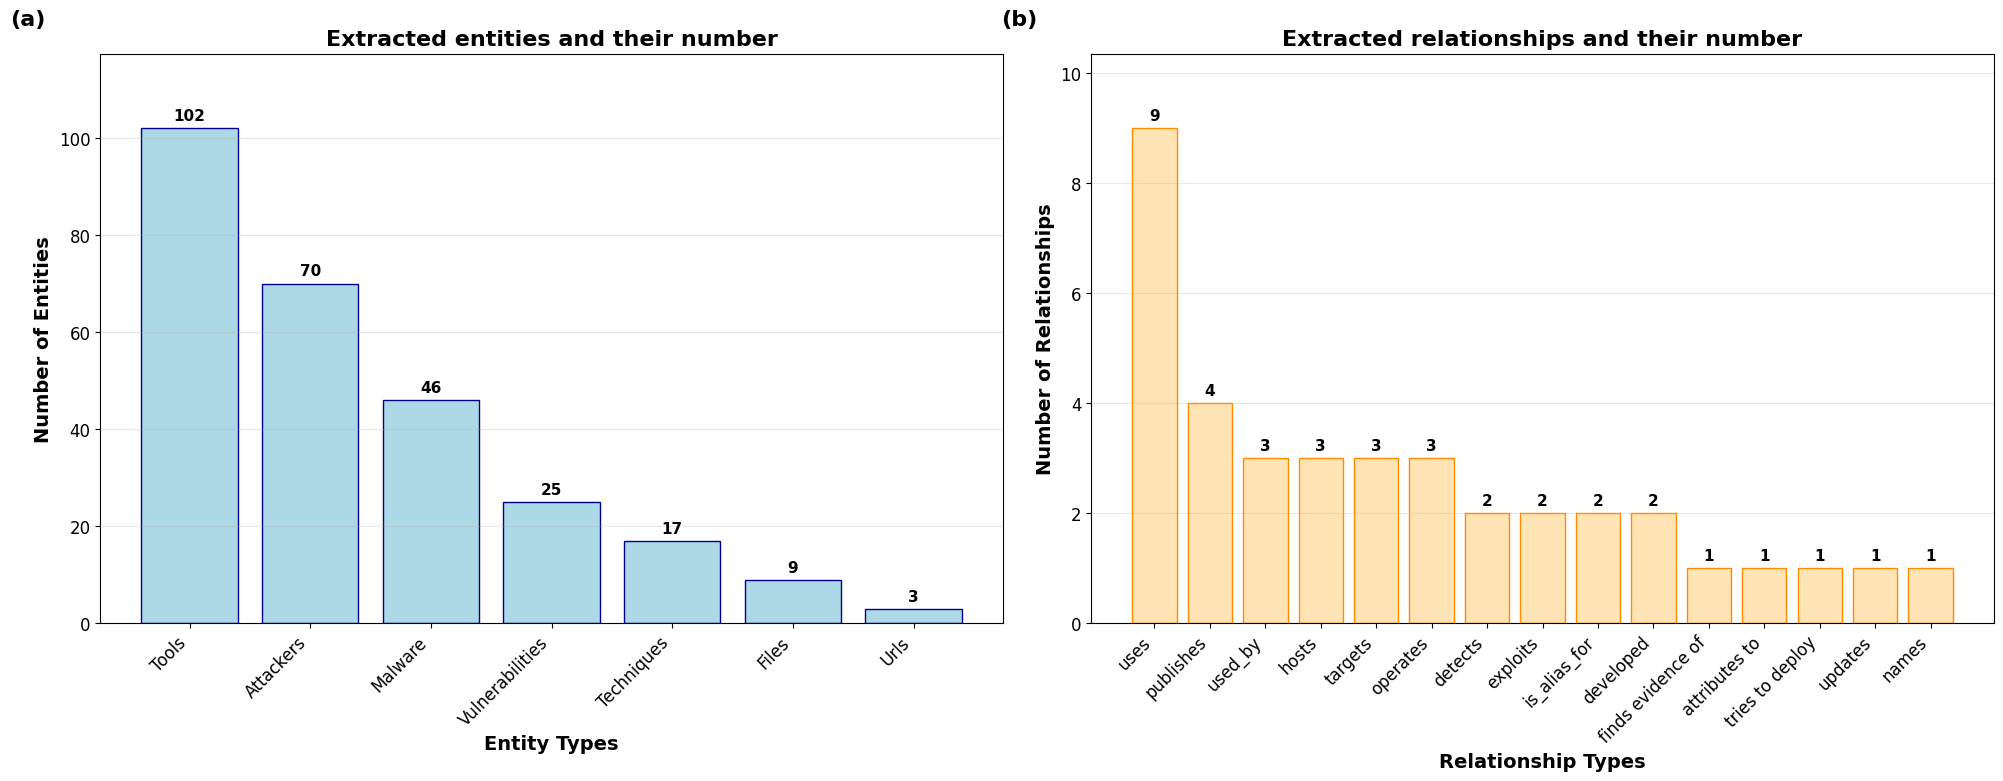


📊 VISUALIZATION STATISTICS:
Total entities plotted: 272
Entity types: 7
Total relationships: 59
Unique relationship types: 36
Top relationships plotted: 15


In [21]:
# Create publication-quality plots similar to Figure 4.4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Extracted entities and their number
if entity_dataframes:
    entity_counts = {name: len(df) for name, df in entity_dataframes.items()}
    
    # Sort by count (descending)
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    entity_names, counts = zip(*sorted_entities)
    
    # Create bar plot with light blue color
    bars1 = ax1.bar(range(len(entity_names)), counts, color='lightblue', edgecolor='darkblue', linewidth=1)
    
    # Customize the plot
    ax1.set_xlabel('Entity Types', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Entities', fontsize=14, fontweight='bold')
    ax1.set_title('Extracted entities and their number', fontsize=16, fontweight='bold')
    ax1.set_xticks(range(len(entity_names)))
    ax1.set_xticklabels([name.replace('_', ' ').title() for name in entity_names], 
                        rotation=45, ha='right', fontsize=12)
    
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars1, counts)):
        ax1.text(i, count + max(counts) * 0.01, f'{count}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Set y-axis limits
    ax1.set_ylim(0, max(counts) * 1.15)
    ax1.grid(True, alpha=0.3, axis='y')

# Right plot: Extracted relationships and their number
if 'relationships_df' in locals():
    relation_counts = relationships_df['relation'].value_counts()
    
    # Get top 15 relationships
    top_relations = relation_counts.head(15)
    relation_names = list(top_relations.index)
    relation_values = list(top_relations.values)
    
    # Create bar plot with light orange/yellow color
    bars2 = ax2.bar(range(len(relation_names)), relation_values, 
                    color='moccasin', edgecolor='darkorange', linewidth=1)
    
    # Customize the plot
    ax2.set_xlabel('Relationship Types', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Relationships', fontsize=14, fontweight='bold')
    ax2.set_title('Extracted relationships and their number', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(relation_names)))
    ax2.set_xticklabels(relation_names, rotation=45, ha='right', fontsize=12)
    
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars2, relation_values)):
        ax2.text(i, count + max(relation_values) * 0.01, f'{count}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Set y-axis limits
    ax2.set_ylim(0, max(relation_values) * 1.15)
    ax2.grid(True, alpha=0.3, axis='y')

# Add subplot labels (a) and (b)
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistics for the plots
print(f"\n📊 VISUALIZATION STATISTICS:")
if entity_dataframes:
    total_entities = sum(len(df) for df in entity_dataframes.values())
    print(f"Total entities plotted: {total_entities:,}")
    print(f"Entity types: {len(entity_dataframes)}")

if 'relationships_df' in locals():
    total_relationships = len(relationships_df)
    unique_relation_types = relationships_df['relation'].nunique()
    print(f"Total relationships: {total_relationships:,}")
    print(f"Unique relationship types: {unique_relation_types}")
    print(f"Top relationships plotted: {min(15, unique_relation_types)}")


## 6. Data Quality Analysis


In [22]:
# Analyze data quality metrics
print("\n🔍 DATA QUALITY ANALYSIS")
print("=" * 40)

# Entity name quality
if entity_dataframes:
    print("\n📝 ENTITY NAME QUALITY:")
    
    quality_data = []
    for entity_type, df in entity_dataframes.items():
        if 'name' in df.columns:
            total_entities = len(df)
            empty_names = df['name'].isnull().sum() + (df['name'] == '').sum()
            unique_names = df['name'].nunique()
            avg_name_length = df['name'].str.len().mean()
            
            quality_data.append({
                'Entity Type': entity_type.title(),
                'Total': total_entities,
                'Empty Names': f"{empty_names} ({empty_names/total_entities*100:.1f}%)",
                'Unique Names': f"{unique_names} ({unique_names/total_entities*100:.1f}%)",
                'Avg Length': f"{avg_name_length:.1f} chars"
            })
    
    quality_df = pd.DataFrame(quality_data)
    print(quality_df.to_string(index=False))

# Relationship quality
if 'relationships_df' in locals():
    print("\n\n🔗 RELATIONSHIP QUALITY:")
    
    total_relationships = len(relationships_df)
    empty_relations = relationships_df['relation'].isnull().sum() + (relationships_df['relation'] == '').sum()
    unique_relations = relationships_df['relation'].nunique()
    
    print(f"  Total relationships: {total_relationships:,}")
    print(f"  Empty relation types: {empty_relations} ({empty_relations/total_relationships*100:.1f}%)")
    print(f"  Unique relation types: {unique_relations}")
    
    # Check for circular relationships
    circular = relationships_df[relationships_df['source_id'] == relationships_df['target_id']]
    print(f"  Circular relationships: {len(circular)} ({len(circular)/total_relationships*100:.1f}%)")
    
    # Most common relationship patterns
    print(f"\n  📈 Top 5 Relationship Types:")
    top_5_relations = relationships_df['relation'].value_counts().head(5)
    for i, (relation, count) in enumerate(top_5_relations.items(), 1):
        percentage = (count / total_relationships) * 100
        print(f"    {i}. {relation}: {count:,} ({percentage:.1f}%)")



🔍 DATA QUALITY ANALYSIS

📝 ENTITY NAME QUALITY:
    Entity Type  Total Empty Names Unique Names Avg Length
      Attackers     70    0 (0.0%)  70 (100.0%)  9.4 chars
        Malware     46    0 (0.0%)  46 (100.0%)  9.3 chars
          Tools    102    0 (0.0%) 102 (100.0%) 10.7 chars
Vulnerabilities     25    0 (0.0%)  25 (100.0%) 13.3 chars
          Files      9    0 (0.0%)   9 (100.0%) 15.1 chars
           Urls      3    0 (0.0%)   3 (100.0%) 19.7 chars
     Techniques     17    0 (0.0%)  17 (100.0%)  9.4 chars


🔗 RELATIONSHIP QUALITY:
  Total relationships: 59
  Empty relation types: 0 (0.0%)
  Unique relation types: 36
  Circular relationships: 0 (0.0%)

  📈 Top 5 Relationship Types:
    1. uses: 9 (15.3%)
    2. publishes: 4 (6.8%)
    3. used_by: 3 (5.1%)
    4. hosts: 3 (5.1%)
    5. targets: 3 (5.1%)


## 7. Export Statistics Summary


In [23]:
# Create summary statistics for export
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_file = f"../data/extraction_statistics_summary_{timestamp}.json"

summary_stats = {
    'timestamp': timestamp,
    'processed_entities': {},
    'relationships': {},
    'model_performance': {},
    'data_quality': {}
}

# Add processed entities stats
if entity_dataframes:
    for entity_type, df in entity_dataframes.items():
        summary_stats['processed_entities'][entity_type] = {
            'total_count': len(df),
            'unique_names': df['name'].nunique() if 'name' in df.columns else 0
        }

# Add relationships stats
if 'relationships_df' in locals():
    summary_stats['relationships'] = {
        'total_count': len(relationships_df),
        'unique_types': relationships_df['relation'].nunique(),
        'top_types': dict(relationships_df['relation'].value_counts().head(10))
    }

# Add model performance
for model_name, stats in model_entity_stats.items():
    summary_stats['model_performance'][model_name] = {
        'total_entities': sum(stats.values()),
        'unique_types': len(stats),
        'top_entities': dict(stats.most_common(5))
    }

# Save summary
try:
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    print(f"\n💾 Statistics summary saved to: {summary_file}")
except Exception as e:
    print(f"❌ Error saving summary: {e}")

# Display final summary
print("\n✨ FINAL SUMMARY")
print("=" * 20)

total_entities = sum(len(df) for df in entity_dataframes.values()) if entity_dataframes else 0
total_relationships = len(relationships_df) if 'relationships_df' in locals() else 0
total_models = len(model_entity_stats)

print(f"📊 Total Processed Entities: {total_entities:,}")
print(f"🔗 Total Relationships: {total_relationships:,}")
print(f"🤖 Models Analyzed: {total_models}")
print(f"📁 Entity Types: {len(entity_dataframes) if entity_dataframes else 0}")

if total_entities > 0 and total_relationships > 0:
    print(f"📈 Entity-to-Relationship Ratio: {total_relationships/total_entities:.2f}")

print(f"\n🕒 Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


❌ Error saving summary: Object of type int64 is not JSON serializable

✨ FINAL SUMMARY
📊 Total Processed Entities: 272
🔗 Total Relationships: 59
🤖 Models Analyzed: 2
📁 Entity Types: 7
📈 Entity-to-Relationship Ratio: 0.22

🕒 Analysis completed at: 2025-08-31 11:49:51


## 2. Entity Statistics Analysis


In [24]:
def extract_entities_from_data(data, model_name):
    """Extract entities from raw extraction data"""
    entity_counts = Counter()
    all_entities = []
    
    for record in data:
        if 'extraction' in record and 'entities' in record['extraction']:
            entities = record['extraction']['entities']
            
            # Handle different entity formats
            if isinstance(entities, list):
                for entity in entities:
                    if isinstance(entity, dict) and 'type' in entity:
                        entity_type = entity['type'].lower()
                        entity_counts[entity_type] += 1
                        all_entities.append({
                            'name': entity.get('name', ''),
                            'type': entity_type,
                            'model': model_name
                        })
    
    return entity_counts, all_entities

# Extract entities for each model
model_entity_stats = {}
all_extracted_entities = []

for model_name, data in extraction_data.items():
    if data:
        entity_counts, entities = extract_entities_from_data(data, model_name)
        model_entity_stats[model_name] = entity_counts
        all_extracted_entities.extend(entities)
        
        print(f"\n📊 {model_name.upper()} Entity Statistics:")
        for entity_type, count in entity_counts.most_common(10):
            print(f"  {entity_type}: {count:,}")

# Create DataFrame for all extracted entities
entities_df = pd.DataFrame(all_extracted_entities)



📊 LLAMA3 Entity Statistics:
  vendor: 256
  threatactor: 212
  malware: 178
  platform: 172
  tool: 134
  geographiclocation: 107
  cve: 66
  technique: 48
  file: 23
  infrastructure: 23

📊 QWEN3_14B Entity Statistics:


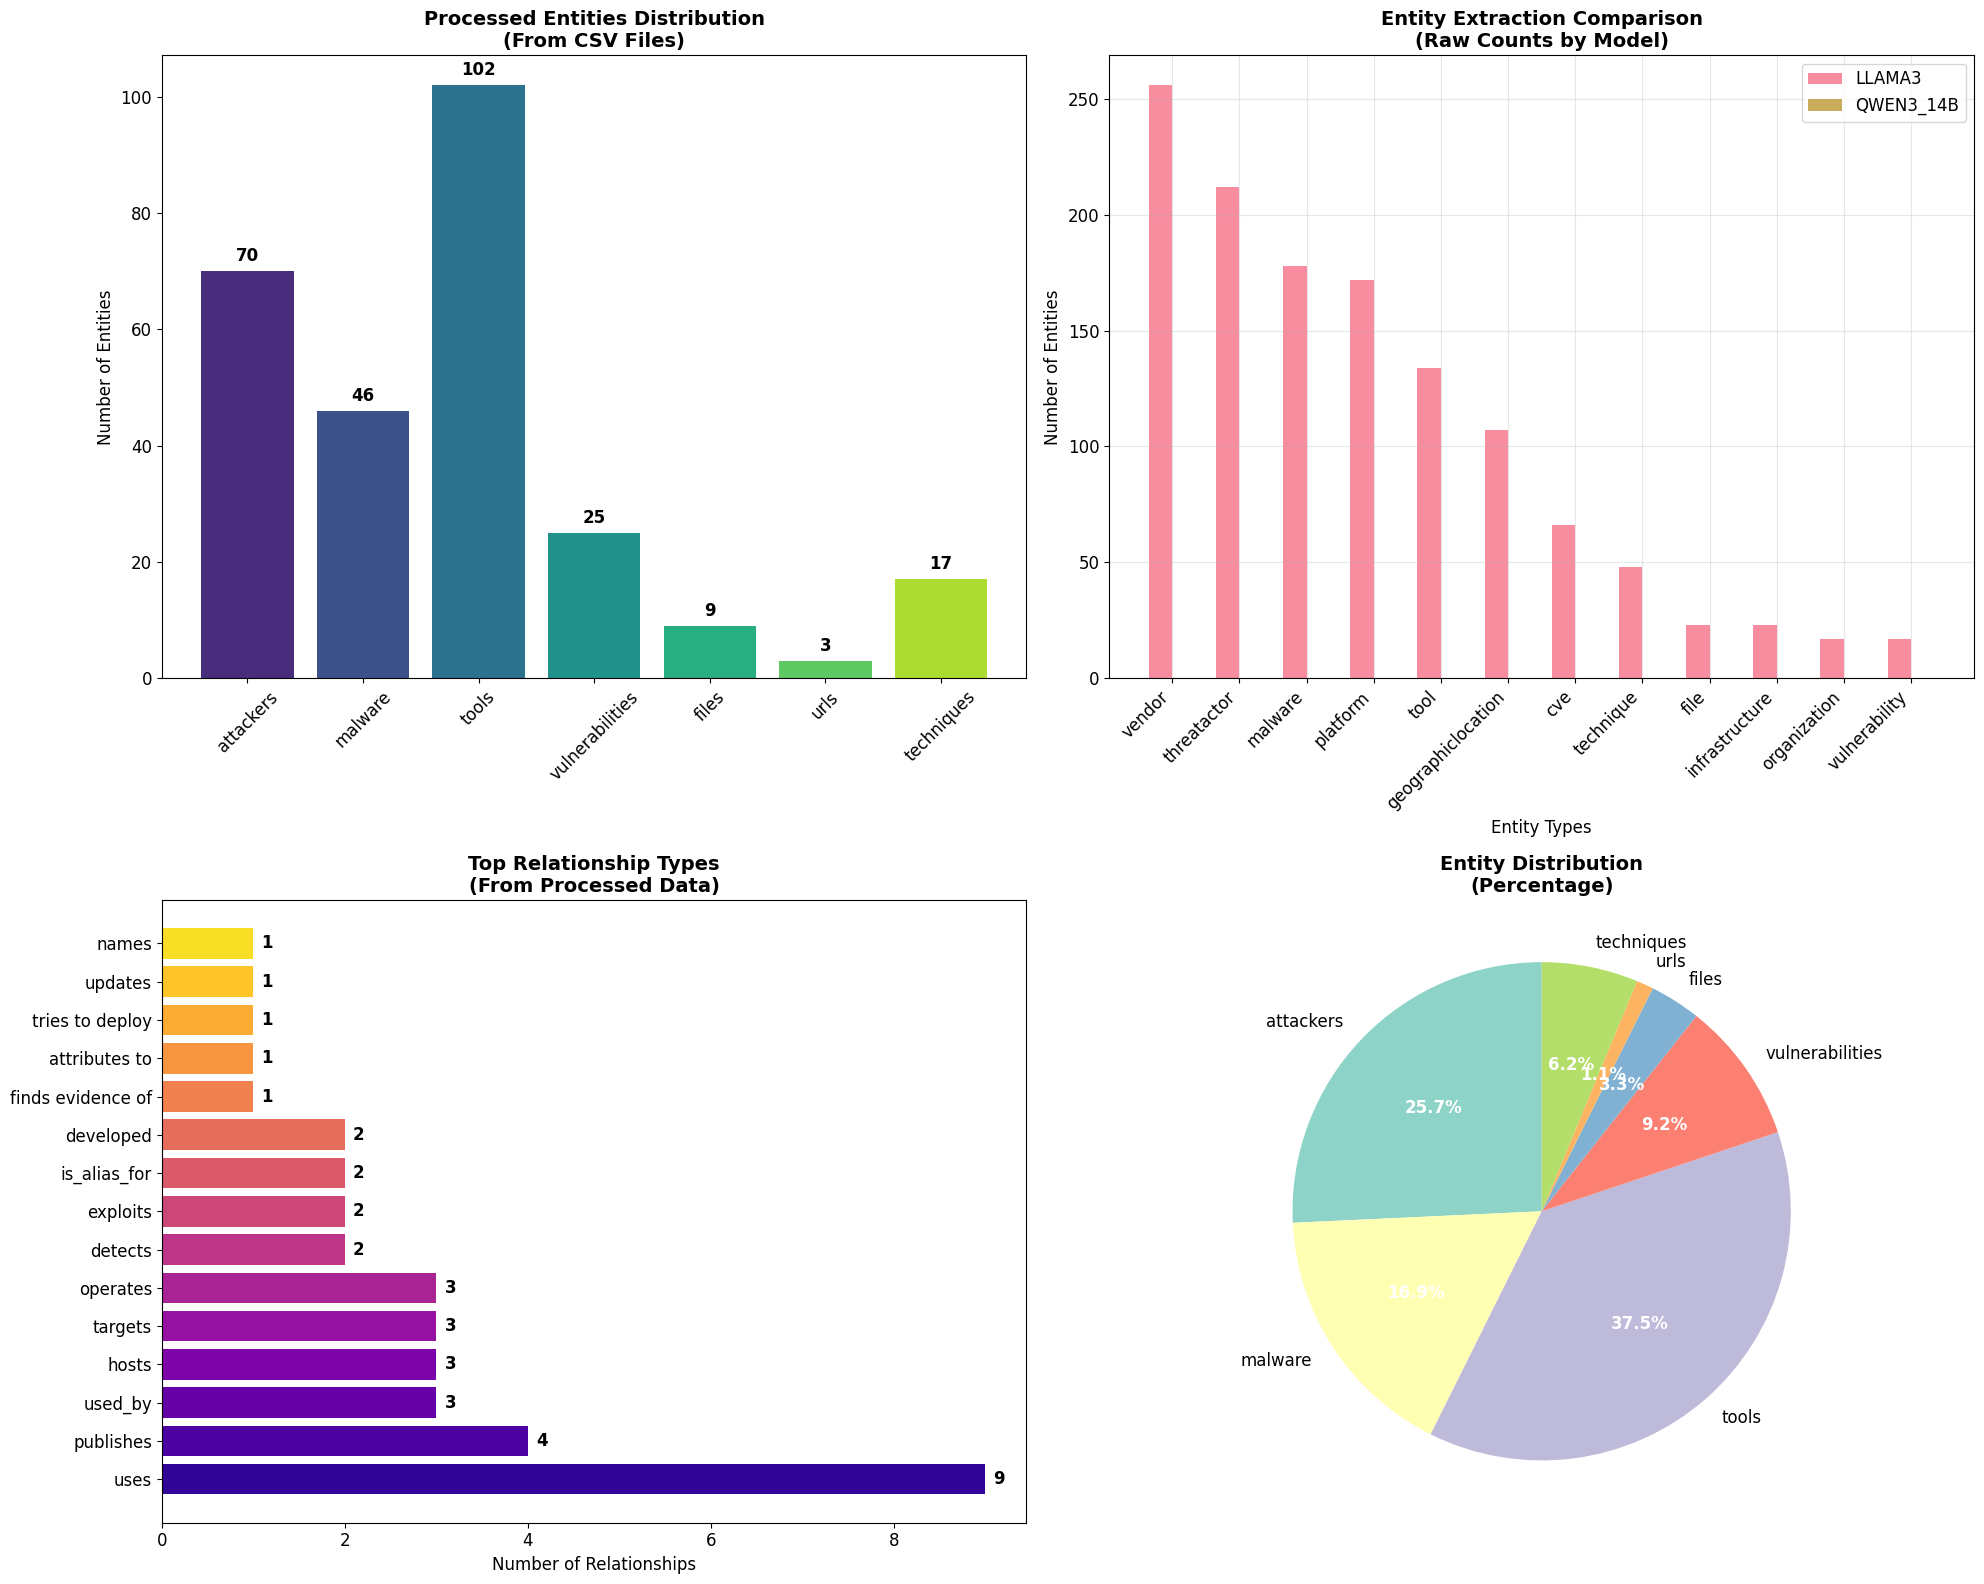

In [25]:
# Plot extracted entities distribution
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Entity counts from processed CSVs
if entity_dataframes:
    processed_counts = {name: len(df) for name, df in entity_dataframes.items()}
    
    ax1 = axes[0, 0]
    entity_types = list(processed_counts.keys())
    counts = list(processed_counts.values())
    
    bars1 = ax1.bar(entity_types, counts, color=sns.color_palette("viridis", len(entity_types)))
    ax1.set_title('Processed Entities Distribution\n(From CSV Files)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Entities')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars1, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 2. Raw extraction comparison between models
if model_entity_stats:
    ax2 = axes[0, 1]
    
    # Get top entity types across all models
    all_types = set()
    for stats in model_entity_stats.values():
        all_types.update(stats.keys())
    
    top_types = sorted(all_types, 
                      key=lambda x: sum(stats.get(x, 0) for stats in model_entity_stats.values()),
                      reverse=True)[:12]
    
    x = np.arange(len(top_types))
    width = 0.35
    
    for i, (model_name, stats) in enumerate(model_entity_stats.items()):
        values = [stats.get(entity_type, 0) for entity_type in top_types]
        ax2.bar(x + i*width, values, width, label=model_name.upper(), alpha=0.8)
    
    ax2.set_title('Entity Extraction Comparison\n(Raw Counts by Model)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Entities')
    ax2.set_xlabel('Entity Types')
    ax2.set_xticks(x + width/2)
    ax2.set_xticklabels(top_types, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Relationship distribution
if 'relationships_df' in locals():
    ax3 = axes[1, 0]
    
    relation_counts = relationships_df['relation'].value_counts().head(15)
    
    bars3 = ax3.barh(range(len(relation_counts)), relation_counts.values,
                     color=sns.color_palette("plasma", len(relation_counts)))
    ax3.set_yticks(range(len(relation_counts)))
    ax3.set_yticklabels(relation_counts.index)
    ax3.set_title('Top Relationship Types\n(From Processed Data)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Number of Relationships')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars3, relation_counts.values)):
        ax3.text(bar.get_width() + max(relation_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count}', ha='left', va='center', fontweight='bold')

# 4. Entity type diversity pie chart
if entity_dataframes:
    ax4 = axes[1, 1]
    
    sizes = list(processed_counts.values())
    labels = list(processed_counts.keys())
    colors = sns.color_palette("Set3", len(labels))
    
    wedges, texts, autotexts = ax4.pie(sizes, labels=labels, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax4.set_title('Entity Distribution\n(Percentage)', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()


## 3. Detailed Statistics Tables


## 8. Advanced Relationship Analysis


In [26]:
# Advanced relationship analysis
if 'relationships_df' in locals():
    print("🔗 ADVANCED RELATIONSHIP ANALYSIS")
    print("=" * 50)
    
    # 1. Relationship type distribution
    relation_stats = relationships_df['relation'].value_counts()
    print(f"\n📊 Total unique relationship types: {len(relation_stats)}")
    print(f"📊 Total relationships: {len(relationships_df):,}")
    
    # 2. Most connected entities (by source)
    print(f"\n🌟 TOP 10 MOST ACTIVE SOURCE ENTITIES:")
    source_counts = relationships_df.groupby(['source_id', 'source_name']).size().reset_index(name='out_degree')
    source_counts = source_counts.sort_values('out_degree', ascending=False).head(10)
    
    for i, row in source_counts.iterrows():
        print(f"  {row.name + 1:2d}. {row['source_name'][:50]:<50} → {row['out_degree']:3d} connections")
    
    # 3. Most connected entities (by target)
    print(f"\n🎯 TOP 10 MOST TARGETED ENTITIES:")
    target_counts = relationships_df.groupby(['target_id', 'target_name']).size().reset_index(name='in_degree')
    target_counts = target_counts.sort_values('in_degree', ascending=False).head(10)
    
    for i, row in target_counts.iterrows():
        print(f"  {row.name + 1:2d}. {row['target_name'][:50]:<50} ← {row['in_degree']:3d} connections")
    
    # 4. Relationship type patterns
    print(f"\n🔄 RELATIONSHIP TYPE PATTERNS:")
    for i, (relation, count) in enumerate(relation_stats.head(15).items(), 1):
        percentage = (count / len(relationships_df)) * 100
        print(f"  {i:2d}. {relation:<30} {count:4d} ({percentage:5.1f}%)")
    
    # 5. Entity type relationship matrix
    print(f"\n🧩 ENTITY TYPE INTERACTION ANALYSIS:")
    
    # Load entity type mapping
    entity_type_mapping = {}
    if entity_dataframes:
        for etype, df in entity_dataframes.items():
            for _, row in df.iterrows():
                entity_type_mapping[row['id']] = etype
    
    # Analyze relationships between entity types
    if entity_type_mapping:
        relationships_df['source_type'] = relationships_df['source_id'].map(entity_type_mapping)
        relationships_df['target_type'] = relationships_df['target_id'].map(entity_type_mapping)
        
        # Create interaction matrix
        interaction_matrix = relationships_df.groupby(['source_type', 'target_type']).size().reset_index(name='count')
        interaction_matrix = interaction_matrix.sort_values('count', ascending=False)
        
        print(f"  Top 10 Entity Type Interactions:")
        for i, row in interaction_matrix.head(10).iterrows():
            if pd.notna(row['source_type']) and pd.notna(row['target_type']):
                print(f"    {i+1:2d}. {row['source_type'].title():<15} → {row['target_type'].title():<15} ({row['count']:3d} relationships)")


🔗 ADVANCED RELATIONSHIP ANALYSIS

📊 Total unique relationship types: 36
📊 Total relationships: 59

🌟 TOP 10 MOST ACTIVE SOURCE ENTITIES:
  27. FortiGuard Labs                                    →   9 connections
  33. Symantec                                           →   4 connections
  30. PyPI                                               →   3 connections
  32. Rust                                               →   3 connections
   7. Lolip0p                                            →   3 connections
   9. RansomHub                                          →   3 connections
  10. Shuckworm                                          →   2 connections
  24. Backdoor.Betruger                                  →   2 connections
  13. Springtail                                         →   2 connections
  35. Windows Users                                      →   2 connections

🎯 TOP 10 MOST TARGETED ENTITIES:
   6. Malware                                            ←   4 connections
  42

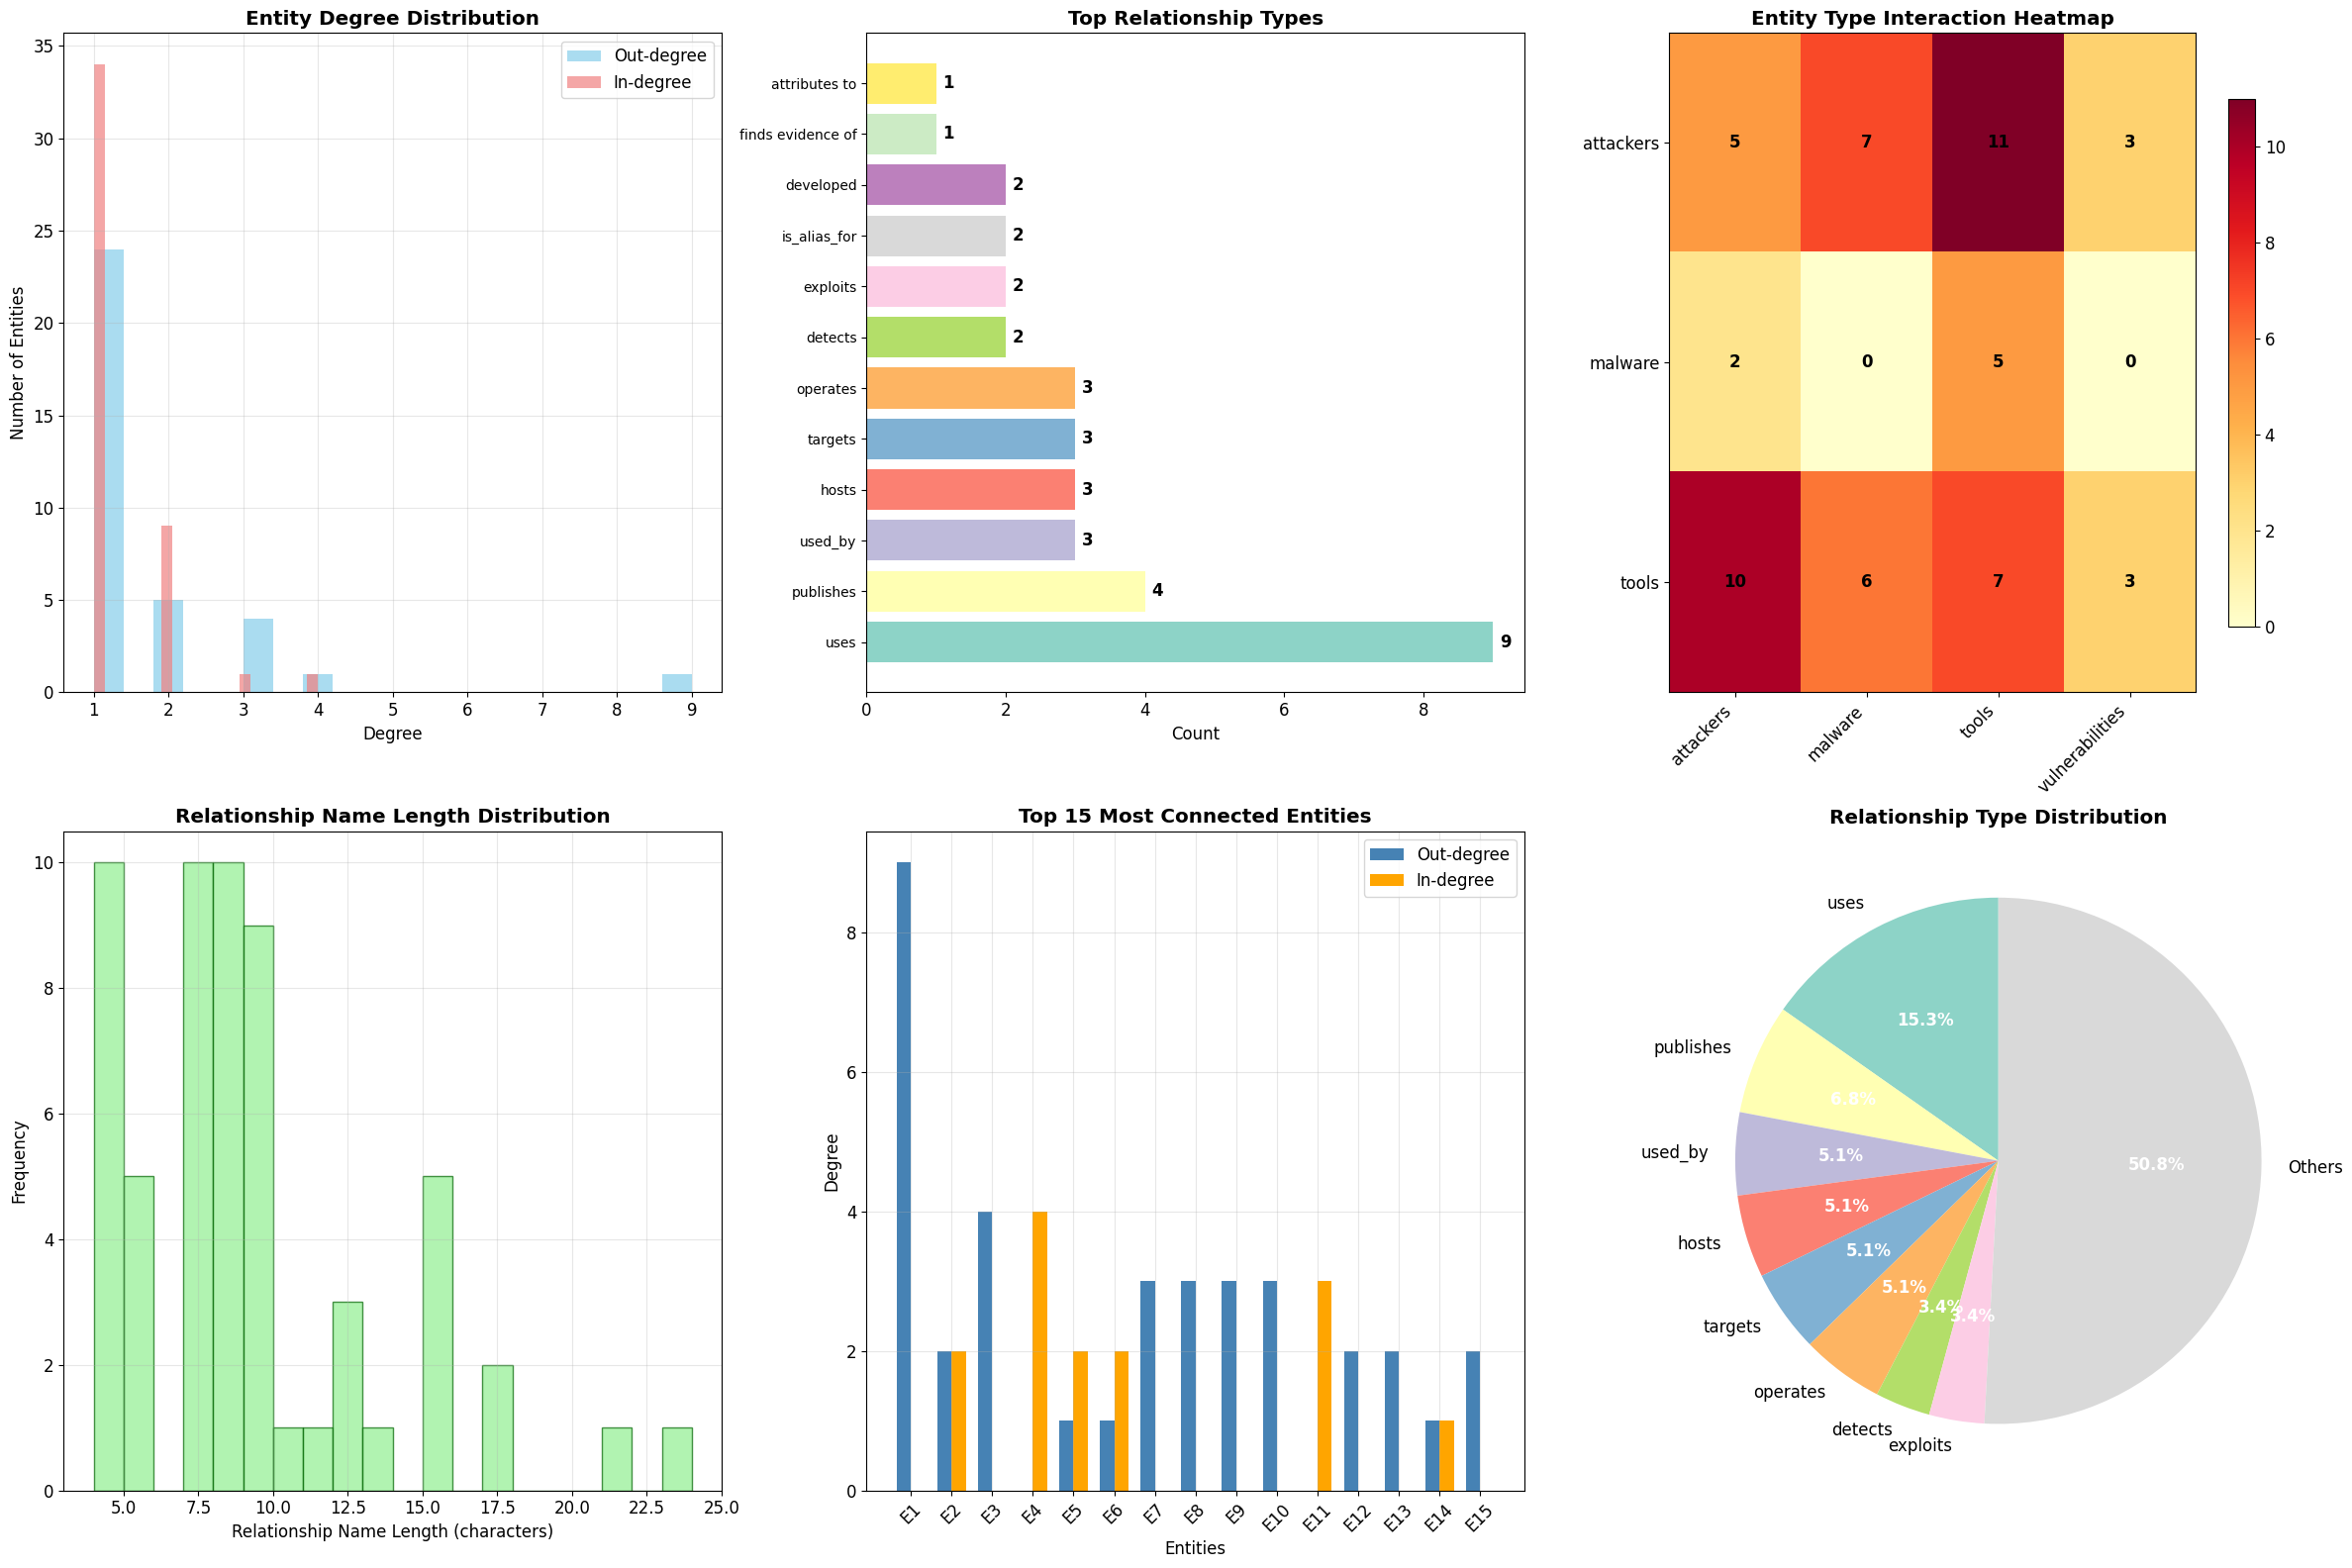

In [27]:
# Create comprehensive relationship visualizations
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

if 'relationships_df' in locals():
    
    # 1. Network degree distribution
    ax1 = axes[0, 0]
    source_degrees = relationships_df['source_id'].value_counts()
    target_degrees = relationships_df['target_id'].value_counts()
    
    ax1.hist(source_degrees.values, bins=20, alpha=0.7, label='Out-degree', color='skyblue')
    ax1.hist(target_degrees.values, bins=20, alpha=0.7, label='In-degree', color='lightcoral')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Number of Entities')
    ax1.set_title('Entity Degree Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Top relationship types (horizontal bar)
    ax2 = axes[0, 1]
    top_relations = relationships_df['relation'].value_counts().head(12)
    y_pos = np.arange(len(top_relations))
    
    bars = ax2.barh(y_pos, top_relations.values, color=plt.cm.Set3(np.arange(len(top_relations))))
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_relations.index, fontsize=10)
    ax2.set_xlabel('Count')
    ax2.set_title('Top Relationship Types', fontweight='bold')
    
    # Add value labels
    for i, v in enumerate(top_relations.values):
        ax2.text(v + max(top_relations.values)*0.01, i, f'{v}', va='center', fontweight='bold')
    
    # 3. Entity type interaction heatmap
    ax3 = axes[0, 2]
    if 'source_type' in relationships_df.columns:
        interaction_pivot = relationships_df.groupby(['source_type', 'target_type']).size().unstack(fill_value=0)
        
        im = ax3.imshow(interaction_pivot.values, cmap='YlOrRd', aspect='auto')
        ax3.set_xticks(range(len(interaction_pivot.columns)))
        ax3.set_yticks(range(len(interaction_pivot.index)))
        ax3.set_xticklabels(interaction_pivot.columns, rotation=45, ha='right')
        ax3.set_yticklabels(interaction_pivot.index)
        ax3.set_title('Entity Type Interaction Heatmap', fontweight='bold')
        
        # Add colorbar
        plt.colorbar(im, ax=ax3, shrink=0.8)
        
        # Add text annotations
        for i in range(len(interaction_pivot.index)):
            for j in range(len(interaction_pivot.columns)):
                text = ax3.text(j, i, interaction_pivot.iloc[i, j],
                               ha="center", va="center", color="black", fontweight='bold')
    
    # 4. Relationship length distribution
    ax4 = axes[1, 0]
    rel_lengths = relationships_df['relation'].str.len()
    ax4.hist(rel_lengths, bins=20, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    ax4.set_xlabel('Relationship Name Length (characters)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Relationship Name Length Distribution', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Most connected entities (combined in/out degree)
    ax5 = axes[1, 1]
    all_entities = pd.concat([
        relationships_df.groupby('source_id').size().to_frame('out_degree'),
        relationships_df.groupby('target_id').size().to_frame('in_degree')
    ], axis=1).fillna(0)
    all_entities['total_degree'] = all_entities['out_degree'] + all_entities['in_degree']
    
    top_connected = all_entities.nlargest(15, 'total_degree')
    
    x_pos = np.arange(len(top_connected))
    width = 0.35
    
    ax5.bar(x_pos - width/2, top_connected['out_degree'], width, label='Out-degree', color='steelblue')
    ax5.bar(x_pos + width/2, top_connected['in_degree'], width, label='In-degree', color='orange')
    
    ax5.set_xlabel('Entities')
    ax5.set_ylabel('Degree')
    ax5.set_title('Top 15 Most Connected Entities', fontweight='bold')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels([f'E{i+1}' for i in range(len(top_connected))], rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Relationship type pie chart
    ax6 = axes[1, 2]
    top_rel_types = relationships_df['relation'].value_counts().head(8)
    others_count = relationships_df['relation'].value_counts().iloc[8:].sum()
    
    if others_count > 0:
        plot_data = list(top_rel_types.values) + [others_count]
        plot_labels = list(top_rel_types.index) + ['Others']
    else:
        plot_data = list(top_rel_types.values)
        plot_labels = list(top_rel_types.index)
    
    colors = plt.cm.Set3(np.arange(len(plot_data)))
    wedges, texts, autotexts = ax6.pie(plot_data, labels=plot_labels, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax6.set_title('Relationship Type Distribution', fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('white')

plt.tight_layout()
plt.show()


## 9. Relationship Pattern Analysis


In [28]:
# Analyze relationship patterns and extract raw relationships from model data
if extraction_data:
    print("🔍 RELATIONSHIP PATTERN ANALYSIS FROM RAW EXTRACTIONS")
    print("=" * 60)
    
    all_raw_relationships = []
    model_relationship_stats = {}
    
    for model_name, data in extraction_data.items():
        if data:
            print(f"\n📊 Analyzing {model_name.upper()} relationships...")
            
            model_relationships = []
            relationship_types = Counter()
            
            for record in data:
                if 'extraction' in record and 'relationships' in record['extraction']:
                    relationships = record['extraction']['relationships']
                    
                    if isinstance(relationships, list):
                        for rel in relationships:
                            if isinstance(rel, list) and len(rel) >= 3:
                                # Format: [source, relation, target]
                                source, relation, target = rel[0], rel[1], rel[2]
                                relationship_types[relation.lower()] += 1
                                model_relationships.append({
                                    'source': source,
                                    'relation': relation.lower(),
                                    'target': target,
                                    'model': model_name
                                })
                            elif isinstance(rel, dict):
                                # Format: {"source": "", "relation": "", "target": ""}
                                if all(key in rel for key in ['source', 'relation', 'target']):
                                    relationship_types[rel['relation'].lower()] += 1
                                    model_relationships.append({
                                        'source': rel['source'],
                                        'relation': rel['relation'].lower(),
                                        'target': rel['target'],
                                        'model': model_name
                                    })
            
            model_relationship_stats[model_name] = relationship_types
            all_raw_relationships.extend(model_relationships)
            
            print(f"  ✅ Found {len(model_relationships):,} relationships")
            print(f"  ✅ Found {len(relationship_types)} unique relationship types")
            
            # Show top relationship types for this model
            print(f"  🔝 Top 10 relationship types:")
            for i, (rel_type, count) in enumerate(relationship_types.most_common(10), 1):
                print(f"    {i:2d}. {rel_type:<30} {count:4d}")
    
    # Create DataFrame for all raw relationships
    if all_raw_relationships:
        raw_relationships_df = pd.DataFrame(all_raw_relationships)
        
        print(f"\n📈 OVERALL RAW RELATIONSHIP STATISTICS:")
        print(f"  Total raw relationships: {len(raw_relationships_df):,}")
        print(f"  Unique relationship types: {raw_relationships_df['relation'].nunique()}")
        print(f"  Models analyzed: {raw_relationships_df['model'].nunique()}")
        
        # Compare processed vs raw relationships
        if 'relationships_df' in locals():
            print(f"\n🔄 PROCESSED vs RAW COMPARISON:")
            print(f"  Processed relationships: {len(relationships_df):,}")
            print(f"  Raw relationships: {len(raw_relationships_df):,}")
            print(f"  Processing ratio: {len(relationships_df)/len(raw_relationships_df)*100:.1f}%")
    
    # Model comparison for relationships
    if len(model_relationship_stats) > 1:
        print(f"\n🏆 MODEL RELATIONSHIP EXTRACTION COMPARISON:")
        
        # Get common relationship types across models
        all_rel_types = set()
        for stats in model_relationship_stats.values():
            all_rel_types.update(stats.keys())
        
        common_types = sorted(all_rel_types, 
                            key=lambda x: sum(stats.get(x, 0) for stats in model_relationship_stats.values()),
                            reverse=True)[:15]
        
        print(f"  Top 15 relationship types across all models:")
        print(f"  {'Relationship Type':<25} ", end="")
        for model_name in model_relationship_stats.keys():
            print(f"{model_name.upper():<15}", end="")
        print()
        print(f"  {'-'*25} ", end="")
        for _ in model_relationship_stats.keys():
            print(f"{'-'*15}", end="")
        print()
        
        for rel_type in common_types:
            print(f"  {rel_type:<25} ", end="")
            for model_name, stats in model_relationship_stats.items():
                count = stats.get(rel_type, 0)
                print(f"{count:<15}", end="")
            print()


🔍 RELATIONSHIP PATTERN ANALYSIS FROM RAW EXTRACTIONS

📊 Analyzing LLAMA3 relationships...
  ✅ Found 605 relationships
  ✅ Found 260 unique relationship types
  🔝 Top 10 relationship types:
     1. uses                             76
     2. targets                          45
     3. exploits                         16
     4. attacks                          16
     5. discovers                         9
     6. publishes                         9
     7. use                               8
     8. communicates_with                 8
     9. develops                          8
    10. used_by                           7

📊 Analyzing QWEN3_14B relationships...
  ✅ Found 3,292 relationships
  ✅ Found 389 unique relationship types
  🔝 Top 10 relationship types:
     1. uses                            657
     2. targets                         427
     3. target                          189
     4. aka                             160
     5. associated with                 137
     6. co

## 10. Raw vs Processed Relationships Visualization


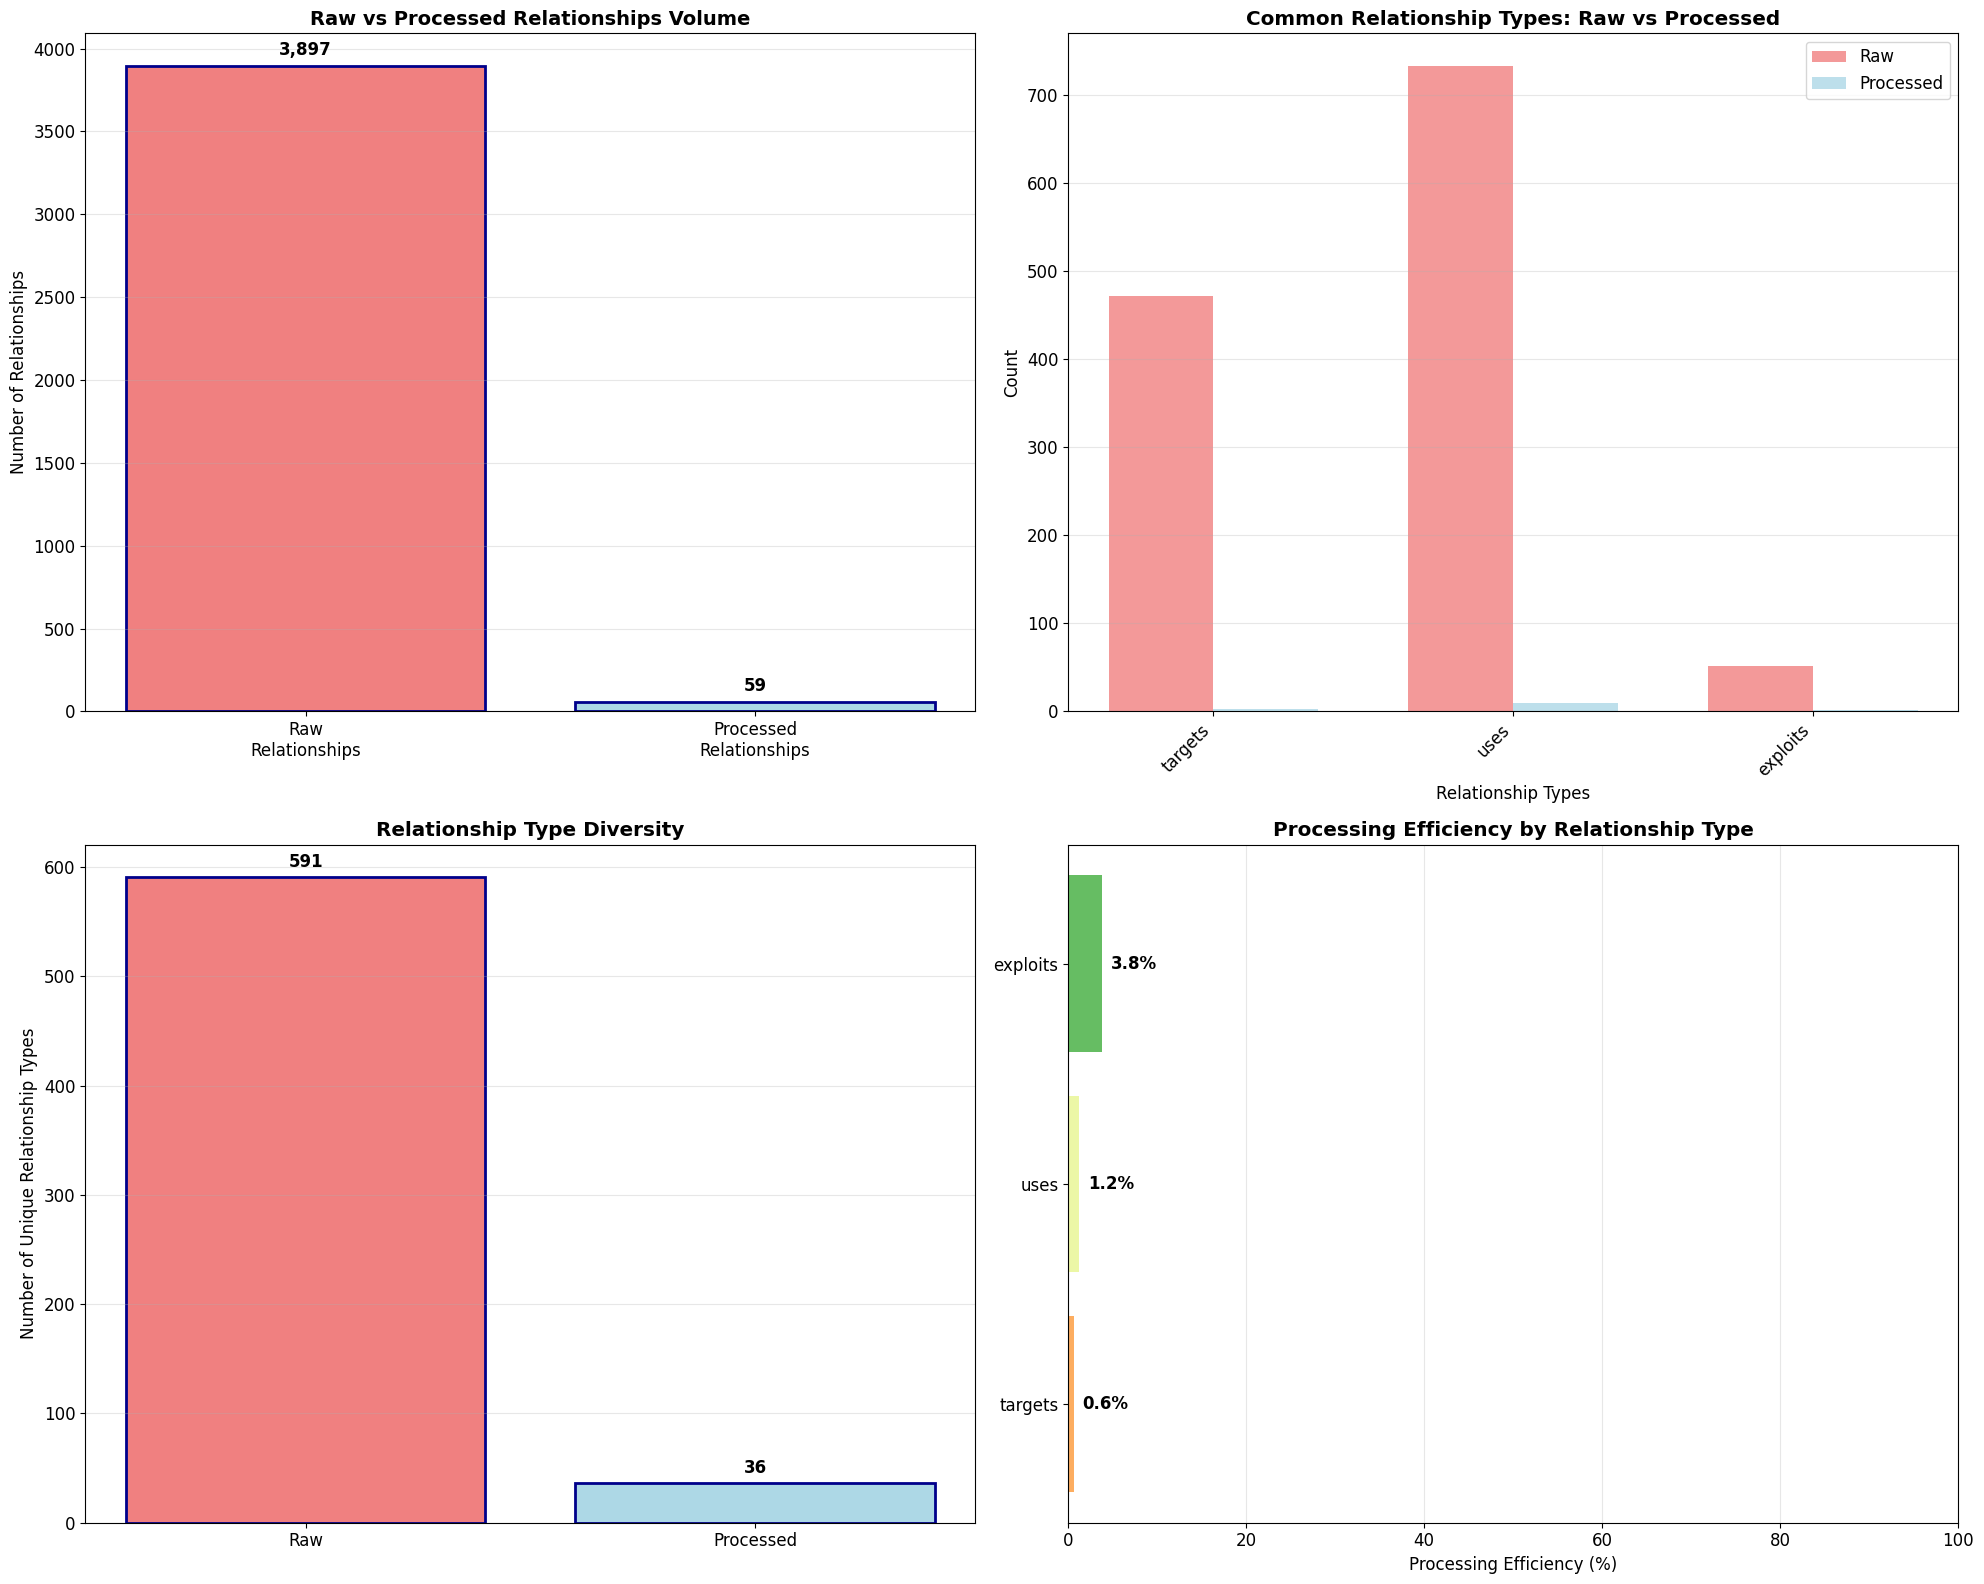


📊 RAW vs PROCESSED RELATIONSHIP SUMMARY:
  Raw relationships: 3,897
  Processed relationships: 59
  Overall processing efficiency: 1.5%
  Raw unique types: 591
  Processed unique types: 36
  Type preservation rate: 6.1%


In [29]:
# Compare raw vs processed relationships
if 'raw_relationships_df' in locals() and 'relationships_df' in locals():
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Volume comparison
    ax1 = axes[0, 0]
    categories = ['Raw\nRelationships', 'Processed\nRelationships']
    values = [len(raw_relationships_df), len(relationships_df)]
    colors = ['lightcoral', 'lightblue']
    
    bars = ax1.bar(categories, values, color=colors, edgecolor='darkblue', linewidth=2)
    ax1.set_ylabel('Number of Relationships')
    ax1.set_title('Raw vs Processed Relationships Volume', fontweight='bold', fontsize=14)
    
    # Add value labels
    for bar, value in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Top relationship types comparison
    ax2 = axes[0, 1]
    raw_top = raw_relationships_df['relation'].value_counts().head(10)
    processed_top = relationships_df['relation'].value_counts().head(10)
    
    # Get common types for comparison
    common_types = set(raw_top.index) & set(processed_top.index)
    common_types = list(common_types)[:8]  # Limit to 8 for readability
    
    if common_types:
        x = np.arange(len(common_types))
        width = 0.35
        
        raw_vals = [raw_top.get(t, 0) for t in common_types]
        proc_vals = [processed_top.get(t, 0) for t in common_types]
        
        ax2.bar(x - width/2, raw_vals, width, label='Raw', color='lightcoral', alpha=0.8)
        ax2.bar(x + width/2, proc_vals, width, label='Processed', color='lightblue', alpha=0.8)
        
        ax2.set_xlabel('Relationship Types')
        ax2.set_ylabel('Count')
        ax2.set_title('Common Relationship Types: Raw vs Processed', fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(common_types, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Relationship type diversity
    ax3 = axes[1, 0]
    diversity_data = {
        'Raw': raw_relationships_df['relation'].nunique(),
        'Processed': relationships_df['relation'].nunique()
    }
    
    bars = ax3.bar(diversity_data.keys(), diversity_data.values(), 
                   color=['lightcoral', 'lightblue'], edgecolor='darkblue', linewidth=2)
    ax3.set_ylabel('Number of Unique Relationship Types')
    ax3.set_title('Relationship Type Diversity', fontweight='bold')
    
    # Add value labels
    for bar, value in zip(bars, diversity_data.values()):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(diversity_data.values())*0.01,
                f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Processing efficiency by relationship type
    ax4 = axes[1, 1]
    if common_types:
        efficiency_ratios = []
        labels = []
        
        for rel_type in common_types[:6]:  # Top 6 for readability
            raw_count = raw_top.get(rel_type, 0)
            proc_count = processed_top.get(rel_type, 0)
            if raw_count > 0:
                ratio = (proc_count / raw_count) * 100
                efficiency_ratios.append(ratio)
                labels.append(rel_type)
        
        colors = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(efficiency_ratios)))
        bars = ax4.barh(range(len(labels)), efficiency_ratios, color=colors)
        
        ax4.set_yticks(range(len(labels)))
        ax4.set_yticklabels(labels)
        ax4.set_xlabel('Processing Efficiency (%)')
        ax4.set_title('Processing Efficiency by Relationship Type', fontweight='bold')
        ax4.set_xlim(0, 100)
        
        # Add value labels
        for i, (bar, ratio) in enumerate(zip(bars, efficiency_ratios)):
            ax4.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{ratio:.1f}%', va='center', fontweight='bold')
        
        ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 RAW vs PROCESSED RELATIONSHIP SUMMARY:")
    print(f"  Raw relationships: {len(raw_relationships_df):,}")
    print(f"  Processed relationships: {len(relationships_df):,}")
    print(f"  Overall processing efficiency: {len(relationships_df)/len(raw_relationships_df)*100:.1f}%")
    print(f"  Raw unique types: {raw_relationships_df['relation'].nunique()}")
    print(f"  Processed unique types: {relationships_df['relation'].nunique()}")
    print(f"  Type preservation rate: {relationships_df['relation'].nunique()/raw_relationships_df['relation'].nunique()*100:.1f}%")


## 11. Enhanced Entity Analysis with New Types


In [30]:
# Enhanced analysis with all entity types including new ones
print("🔍 ENHANCED ENTITY ANALYSIS WITH NEW TYPES")
print("=" * 60)

# Get all available entity types
all_entity_types = list(entity_dataframes.keys())
print(f"📊 Total entity types available: {len(all_entity_types)}")
print(f"📝 Entity types: {', '.join(all_entity_types)}")

# New entity types focus
new_entity_types = ['ips', 'urls', 'devices', 'techniques']
available_new_types = [et for et in new_entity_types if et in entity_dataframes]

if available_new_types:
    print(f"\n🆕 NEW ENTITY TYPES ANALYSIS:")
    for entity_type in available_new_types:
        df = entity_dataframes[entity_type]
        print(f"\n  📂 {entity_type.upper()}:")
        print(f"    Total count: {len(df):,}")
        print(f"    Unique names: {df['name'].nunique()}")
        
        # Show samples
        if len(df) > 0:
            print(f"    Sample entities:")
            sample_size = min(5, len(df))
            for i, row in df.head(sample_size).iterrows():
                print(f"      • {row['name']}")
else:
    print(f"\n⚠️  No new entity types found in current data")
    print(f"   Available types: {all_entity_types}")

# Entity type distribution comparison
print(f"\n📊 COMPLETE ENTITY TYPE DISTRIBUTION:")
entity_counts = {}
for entity_type, df in entity_dataframes.items():
    entity_counts[entity_type] = len(df)

# Sort by count
sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

total_entities = sum(entity_counts.values())
print(f"   Total entities across all types: {total_entities:,}")
print(f"   Distribution:")

for entity_type, count in sorted_entities:
    percentage = (count / total_entities) * 100 if total_entities > 0 else 0
    bar = "█" * int(percentage / 2)  # Visual bar
    print(f"   {entity_type:<15} {count:6,} ({percentage:5.1f}%) {bar}")

# Identify rare vs common entity types
common_threshold = total_entities * 0.05  # 5% threshold
rare_types = [et for et, count in entity_counts.items() if count < common_threshold]
common_types = [et for et, count in entity_counts.items() if count >= common_threshold]

if rare_types:
    print(f"\n🔍 RARE ENTITY TYPES (< 5% of total):")
    for et in rare_types:
        print(f"   • {et}: {entity_counts[et]} entities")

if common_types:
    print(f"\n⭐ COMMON ENTITY TYPES (≥ 5% of total):")
    for et in common_types:
        print(f"   • {et}: {entity_counts[et]} entities")


🔍 ENHANCED ENTITY ANALYSIS WITH NEW TYPES
📊 Total entity types available: 7
📝 Entity types: attackers, malware, tools, vulnerabilities, files, urls, techniques

🆕 NEW ENTITY TYPES ANALYSIS:

  📂 URLS:
    Total count: 3
    Unique names: 3
    Sample entities:
      • Energoatom
      • hxxps://cdn[.]discordapp[.]com/attachments/10
      • PyPI

  📂 TECHNIQUES:
    Total count: 17
    Unique names: 17
    Sample entities:
      • AES
      • API keys
      • DBatLoader
      • Flutter
      • Internet Macros

📊 COMPLETE ENTITY TYPE DISTRIBUTION:
   Total entities across all types: 272
   Distribution:
   tools              102 ( 37.5%) ██████████████████
   attackers           70 ( 25.7%) ████████████
   malware             46 ( 16.9%) ████████
   vulnerabilities     25 (  9.2%) ████
   techniques          17 (  6.2%) ███
   files                9 (  3.3%) █
   urls                 3 (  1.1%) 

🔍 RARE ENTITY TYPES (< 5% of total):
   • files: 9 entities
   • urls: 3 entities

⭐ COMMON 

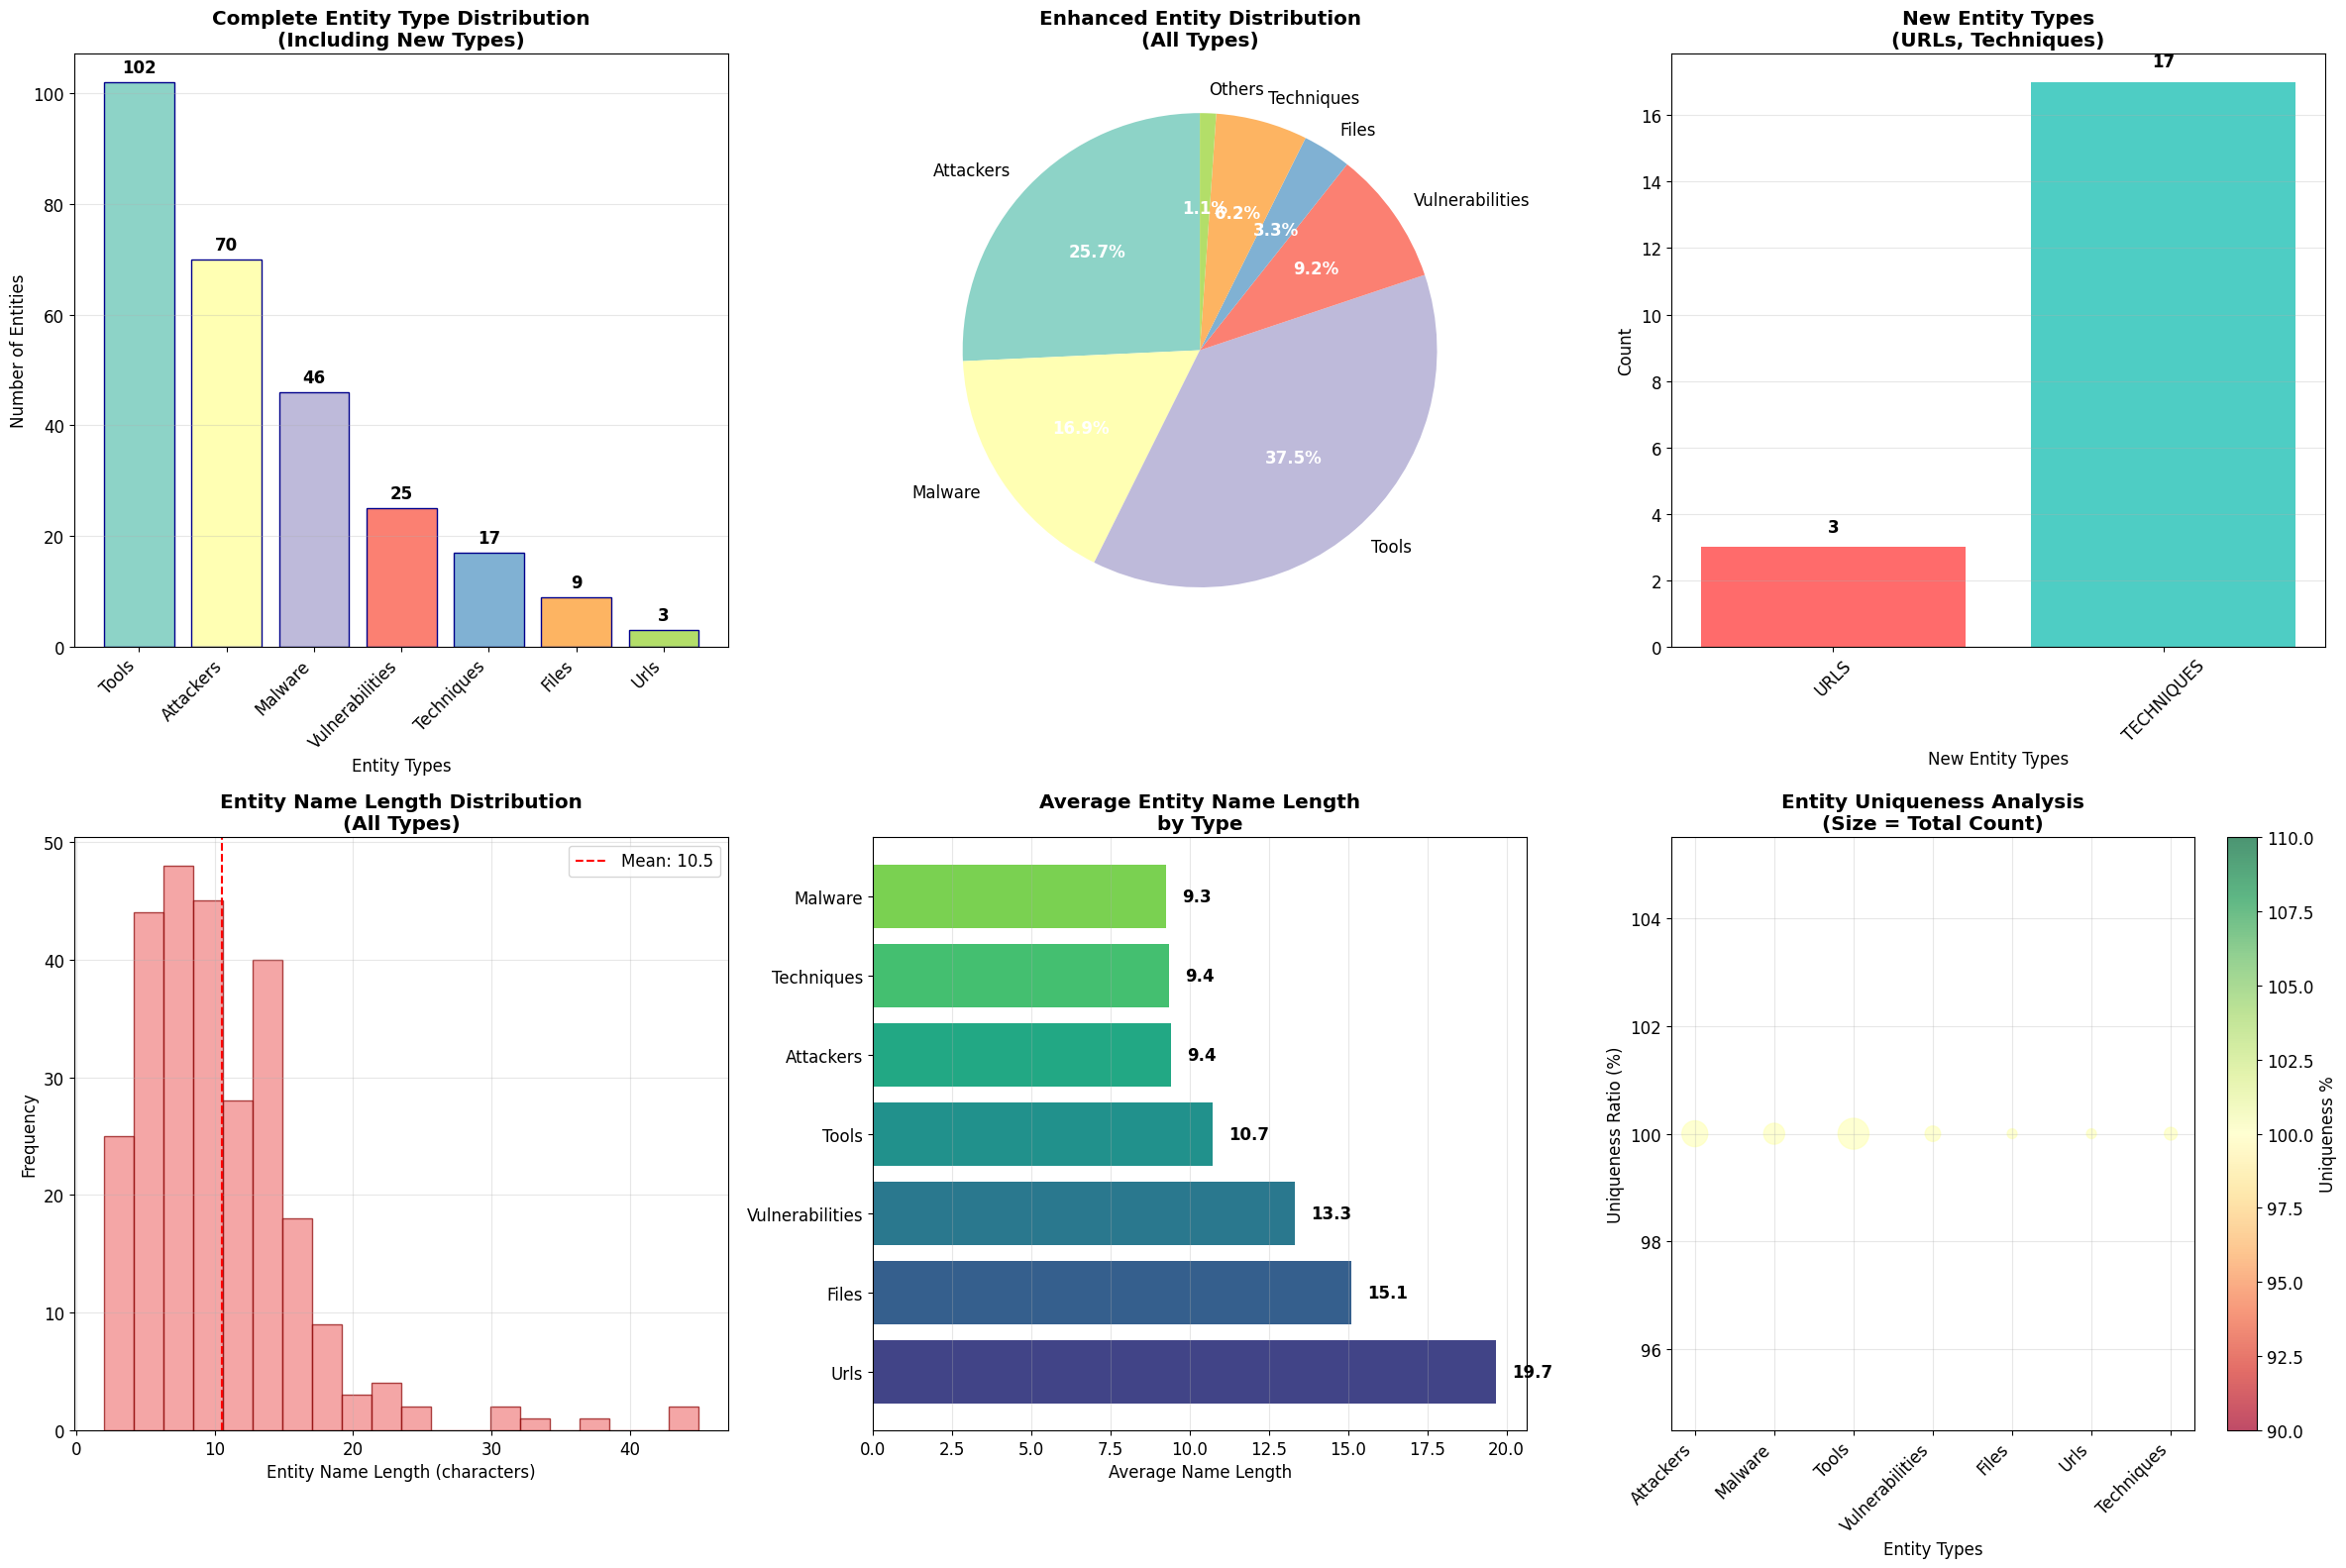


✨ ENHANCED ENTITY STATISTICS SUMMARY:
📊 Total entities (all types): 272
🏷️  Total entity types: 7
🆕 New entity types count: 20
🆕 New types: urls, techniques
🥇 Most common type: tools (102 entities)
🏁 Least common type: urls (3 entities)
📏 Average entity name length: 10.5 characters
📏 Longest entity name: 45 characters
📏 Shortest entity name: 2 characters


In [31]:
# Create enhanced visualizations including all entity types
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# 1. Complete entity distribution (all types)
ax1 = axes[0, 0]
if entity_dataframes:
    all_counts = {name: len(df) for name, df in entity_dataframes.items()}
    sorted_items = sorted(all_counts.items(), key=lambda x: x[1], reverse=True)
    
    entity_names, counts = zip(*sorted_items)
    colors = plt.cm.Set3(np.arange(len(entity_names)))
    
    bars = ax1.bar(range(len(entity_names)), counts, color=colors, edgecolor='darkblue', linewidth=1)
    ax1.set_xlabel('Entity Types')
    ax1.set_ylabel('Number of Entities')
    ax1.set_title('Complete Entity Type Distribution\n(Including New Types)', fontweight='bold')
    ax1.set_xticks(range(len(entity_names)))
    ax1.set_xticklabels([name.replace('_', ' ').title() for name in entity_names], 
                        rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        ax1.text(i, count + max(counts) * 0.01, f'{count}', 
                ha='center', va='bottom', fontweight='bold')
    
    ax1.grid(True, alpha=0.3, axis='y')

# 2. Entity type diversity pie chart (enhanced)
ax2 = axes[0, 1]
if entity_dataframes:
    sizes = list(all_counts.values())
    labels = [name.replace('_', ' ').title() for name in all_counts.keys()]
    colors = plt.cm.Set3(np.arange(len(labels)))
    
    # Combine small categories
    threshold = sum(sizes) * 0.02  # 2% threshold
    large_sizes = []
    large_labels = []
    small_total = 0
    
    for size, label in zip(sizes, labels):
        if size >= threshold:
            large_sizes.append(size)
            large_labels.append(label)
        else:
            small_total += size
    
    if small_total > 0:
        large_sizes.append(small_total)
        large_labels.append('Others')
    
    wedges, texts, autotexts = ax2.pie(large_sizes, labels=large_labels, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax2.set_title('Enhanced Entity Distribution\n(All Types)', fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

# 3. New entity types focus
ax3 = axes[0, 2]
new_types_data = {et: len(entity_dataframes[et]) for et in available_new_types if et in entity_dataframes}

if new_types_data:
    bars = ax3.bar(range(len(new_types_data)), list(new_types_data.values()), 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax3.set_xlabel('New Entity Types')
    ax3.set_ylabel('Count')
    ax3.set_title('New Entity Types\n(URLs, Techniques)', fontweight='bold')
    ax3.set_xticks(range(len(new_types_data)))
    ax3.set_xticklabels([name.upper() for name in new_types_data.keys()], rotation=45)
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, new_types_data.values())):
        ax3.text(i, count + max(new_types_data.values()) * 0.02, f'{count}', 
                ha='center', va='bottom', fontweight='bold')
    
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No new entity types\nwith data found', 
             ha='center', va='center', transform=ax3.transAxes,
             fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    ax3.set_title('New Entity Types', fontweight='bold')

# 4. Entity name length analysis
ax4 = axes[1, 0]
all_lengths = []
type_lengths = {}

for entity_type, df in entity_dataframes.items():
    if 'name' in df.columns:
        lengths = df['name'].str.len().tolist()
        all_lengths.extend(lengths)
        type_lengths[entity_type] = np.mean(lengths)

if all_lengths:
    ax4.hist(all_lengths, bins=20, color='lightcoral', alpha=0.7, edgecolor='darkred')
    ax4.set_xlabel('Entity Name Length (characters)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Entity Name Length Distribution\n(All Types)', fontweight='bold')
    ax4.axvline(np.mean(all_lengths), color='red', linestyle='--', 
                label=f'Mean: {np.mean(all_lengths):.1f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Average name length by type
ax5 = axes[1, 1]
if type_lengths:
    sorted_types = sorted(type_lengths.items(), key=lambda x: x[1], reverse=True)
    type_names, avg_lengths = zip(*sorted_types)
    
    bars = ax5.barh(range(len(type_names)), avg_lengths, 
                    color=plt.cm.viridis(np.linspace(0.2, 0.8, len(type_names))))
    ax5.set_yticks(range(len(type_names)))
    ax5.set_yticklabels([name.replace('_', ' ').title() for name in type_names])
    ax5.set_xlabel('Average Name Length')
    ax5.set_title('Average Entity Name Length\nby Type', fontweight='bold')
    
    # Add value labels
    for i, (bar, length) in enumerate(zip(bars, avg_lengths)):
        ax5.text(length + 0.5, i, f'{length:.1f}', va='center', fontweight='bold')
    
    ax5.grid(True, alpha=0.3, axis='x')

# 6. Entity coverage analysis
ax6 = axes[1, 2]
coverage_data = []
for entity_type, df in entity_dataframes.items():
    total = len(df)
    unique = df['name'].nunique() if 'name' in df.columns else 0
    coverage = (unique / total * 100) if total > 0 else 0
    coverage_data.append((entity_type, coverage, total))

if coverage_data:
    coverage_data.sort(key=lambda x: x[1], reverse=True)
    types, coverages, totals = zip(*coverage_data)
    
    # Create scatter plot with size based on total count
    sizes = [max(50, min(500, t * 5)) for t in totals]  # Scale sizes
    scatter = ax6.scatter(range(len(types)), coverages, s=sizes, 
                         c=coverages, cmap='RdYlGn', alpha=0.7)
    
    ax6.set_xlabel('Entity Types')
    ax6.set_ylabel('Uniqueness Ratio (%)')
    ax6.set_title('Entity Uniqueness Analysis\n(Size = Total Count)', fontweight='bold')
    ax6.set_xticks(range(len(types)))
    ax6.set_xticklabels([t.replace('_', ' ').title() for t in types], rotation=45, ha='right')
    ax6.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax6, label='Uniqueness %')

plt.tight_layout()
plt.show()

# Print enhanced summary
print(f"\n✨ ENHANCED ENTITY STATISTICS SUMMARY:")
if entity_dataframes:
    total_all = sum(len(df) for df in entity_dataframes.values())
    print(f"📊 Total entities (all types): {total_all:,}")
    print(f"🏷️  Total entity types: {len(entity_dataframes)}")
    
    if available_new_types:
        new_total = sum(len(entity_dataframes[et]) for et in available_new_types)
        print(f"🆕 New entity types count: {new_total}")
        print(f"🆕 New types: {', '.join(available_new_types)}")
    
    # Most and least common types
    sorted_counts = sorted(all_counts.items(), key=lambda x: x[1], reverse=True)
    print(f"🥇 Most common type: {sorted_counts[0][0]} ({sorted_counts[0][1]} entities)")
    print(f"🏁 Least common type: {sorted_counts[-1][0]} ({sorted_counts[-1][1]} entities)")
    
    if all_lengths:
        print(f"📏 Average entity name length: {np.mean(all_lengths):.1f} characters")
        print(f"📏 Longest entity name: {max(all_lengths)} characters")
        print(f"📏 Shortest entity name: {min(all_lengths)} characters")
